# Classification Problem With Some Useless Variables

In this tutorial we go through a classification problem with a moderate number of explanatory variables (4) that are not equally insightful. 

We provide an intuitive qualitative/visual analysis of the importance of each variable, and show that it is consistent with the variable selection analysis of th `kxy` package. 

We then show how the data-driven improvability analysis of the `kxy` package may be used to quantify how complementary a set of new explanatory variables may be to a set of existing explanatory variables in a classification problem.

The dataset used is the UCI bank note dataset. The goal is to use properties of a picture of a bank note to determine whether the note is a forgery.


In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["NUMEXPR_MAX_THREADS"] = '8'
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import kxy

In [2]:
# We load the data
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00267/' \
    'data_banknote_authentication.txt'
df = pd.read_csv(url, names=['Variance', 'Skewness', 'Kurtosis', 'Entropy', 'Is Fake'])

# Next, we normalize the data so that each input takes value in $[0, 1]$, so as to ease visualization. 
# All input importance analyses performed by the `kxy` package are robust to increasing transformations, 
# including the foregoing normalization. Nonetheless, we will take a copy of the data before normalization,
# which we will use for analyses, the normalized data being used for visualization only.
ef = df.copy() # Copy used for analysis.
# Normalization to ease vizualization
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] = \
    (df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] - \
     df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].min(axis=0))
df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']] /= \
    df[['Variance', 'Skewness', 'Kurtosis', 'Entropy']].max(axis=0)

## Variable Selection

### Intuition

We begin by forming an intuition for what we would expect out of a variable importance analysis.

#### Univariate Variable Importance
Intuitively, saying that an input $x_i$ is informative about a categorical label $y$ (when used in isolation) is the same as saying that observing the value of $x_i$ is useful for inferring the value of the label/class $y$. For this to be true, it ought to be the case that the collection of values of $x_i$ corresponding to a given value of $y$ should be sufficiently different from the collections of values of $x_i$ corresponding to the other classes. 

The more these collections are *different*, the less ambiguity there will be in inferring $y$ from $x_i$, and therefore the more useful $x_i$ will be for inferring $y$ in isolation.

In the case of the bank note dataset, for every one of the four inputs of interest, we can plot all values on the same line, and color each point red or green depending on whether the observed input came from a fake note or not. 

The more distinguishable the collection of red ticks is from the collection of green ticks, the more the corresponding input is useful at predicting whether or not a bank note is a forgery.

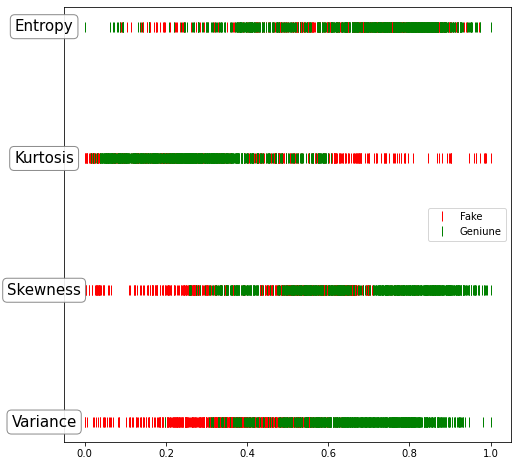

In [3]:
import pylab as plt
import numpy as np

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

y = df['Is Fake'].values.astype(bool)
v = df['Variance'].values
s = df['Skewness'].values
k = df['Kurtosis'].values
e = df['Entropy'].values

bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)
ax.plot(v[y], 0.0*np.ones_like(v[y]), '|', color='r', linewidth=2, markersize=10,\
        label='Fake')
ax.plot(v[~y], 0.0*np.ones_like(v[~y]), '|', color='g', linewidth=2, markersize=10,\
        label='Geniune')
ax.text(-0.1, 0, "Variance", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(s[y], 0.1*np.ones_like(s[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(s[~y], 0.1*np.ones_like(s[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.1, "Skewness", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(k[y], 0.2*np.ones_like(k[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(k[~y], 0.2*np.ones_like(k[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.2, "Kurtosis", ha="center", va="center", size=15, bbox=bbox_props)
ax.plot(e[y], 0.3*np.ones_like(e[y]), '|', color='r', linewidth=2, markersize=10)
ax.plot(e[~y], 0.3*np.ones_like(e[~y]), '|', color='g', linewidth=2, markersize=10)
ax.text(-0.1, 0.3, "Entropy", ha="center", va="center", size=15, bbox=bbox_props)
ax.axes.yaxis.set_visible(False)
plt.legend()
plt.show()

In [4]:
'Percentage of points with a normalized kurtosis higher than 0.6: %.2f%%' %\
    (100.*(df['Kurtosis'] > 0.6).mean())

'Percentage of points with a normalized kurtosis higher than 0.6: 7.43%'

Clearly, from the plot above, it is visually very hard to differenciate geniune bank notes from forgeries solely using the `Entropy` input. 

As for the `Kurtosis` variable, while a normalized kurtosis higher than 0.6 is a strong indication that the bank note is a forgery, this only happens about 7% of the time. When the normalized kurtosis is lower than 0.6 on the other hand, it is very hard to distinguish geniune notes from forgeries using the kurtosis alone. 

The `Skewness` input is visually more useful than the previously mentioned two inputs, but the `Variance` input is clearly the most useful. Geniune bank notes tend to have a higher variance, and forgeries tend to have a lower variance.

#### Incremental Variable Importance

Let's move on to guessing what would happen when some variables are used together. Of particular interest is the ability to detect variables that are redundant and inputs that are complementary.

Redundant inputs should be avoided as they might result in *overfitting* during the training phase. On the other hand, an input that is complementary to other inputs could shed some light where said inputs are not sufficiently informative to accurately predict the label.

Let's try to form an intuitive understanding of the marginal usefulness of our four inputs for predicting whether a bank note is a forgery. As the previous analysis suggested, clearly `Variance` is the input with the highest usefulness when used in isolation. 

To figure out which of the three remaining inputs would complement `Variance` the best, we make three 2D scatter plots with `Variance` as the x-axis and the other input as the y-axis and, as always, we color dots green (resp. red) when the associated inputs came from a geniune (resp. fake) bank note. 

Intuitively, the input that complements `Variance` the best is the one where the collections of green and red points are the most distinguishable. The more distinguishable these two collections, the more accurate it would be to predict whether the bank note is a forgery. The more the two collections overlap, the more ambiguous our prediction will be.

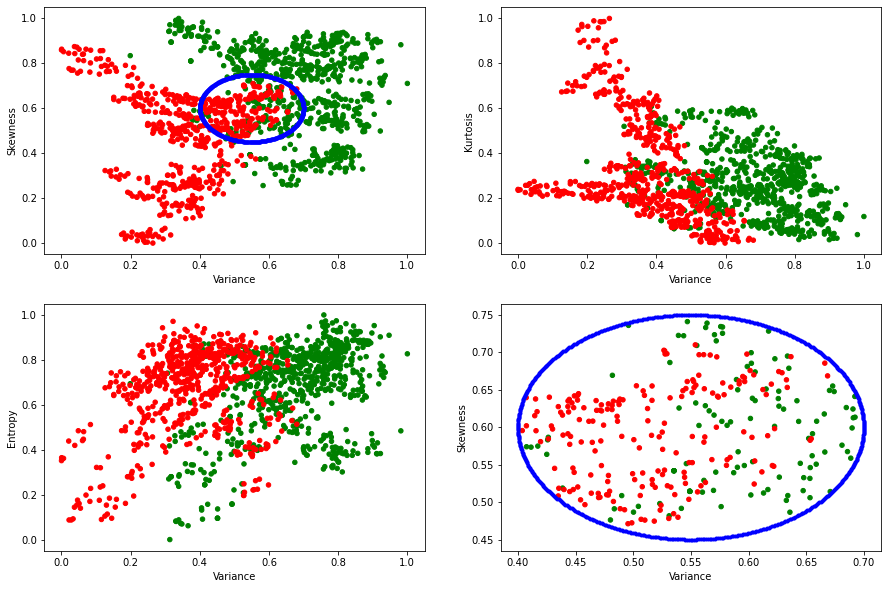

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
df.plot.scatter(ax=ax[0, 0], x='Variance', y='Skewness', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[0, 1], x='Variance', y='Kurtosis', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
df.plot.scatter(ax=ax[1, 0], x='Variance', y='Entropy', c=df['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
theta = np.arange(0, 2*np.pi, 0.01)
bound_x = 0.55 + 0.15*np.cos(theta)
bound_y = 0.6 + 0.15*np.sin(theta)
ax[0, 0].plot(bound_x, bound_y, '.', c='b')

selector = (((df['Variance']-0.55)/0.15)**2 + ((df['Skewness']-0.6)/0.15)**2) <=1
cf = df[selector]
cf.plot.scatter(ax=ax[1, 1], x='Variance', y='Skewness', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
ax[1, 1].plot(bound_x, bound_y, '.', c='b')
plt.show()

As it can be seen above, it is in the plot `Variance` x `Skewness` that the collections of green and red points overlap the least. Thus, one would conclude that `Skewness` is the input that should be expected to complement `Variance` the most.

To qualitatively determine which of `Entropy` or `Kurtosis` would complement the pair (`Variance`, `Skewness`) the most, we identity values of the pair (`Variance`, `Skewness`) that are jointly inconclusive about whether the bank note is a forgery. This is the region of the `Variance` x `Skewness` plane where green dots and red dots overlap. We have crudely idendified this region in the top-left plot with the blue ellipse, a zoomed-in version thereof is displayed in the bottom right plot. 

We then seek to know which of `Entropy` and `Kurtosis` can best help alleviate the ambiguity inherent to that region. To do so, we consider all the bank notes that fall within the blue ellipse above, and we plot them on the four planes `Variance` x `Kurtosis`, `Variance` x `Entropy`, `Skewness` x `Kurtosis`, and `Skewness` x `Entropy`, in an attempt to figure out how much ambiguity we can remove at a glance by knowing `Entropy` or `Kurtosis`.

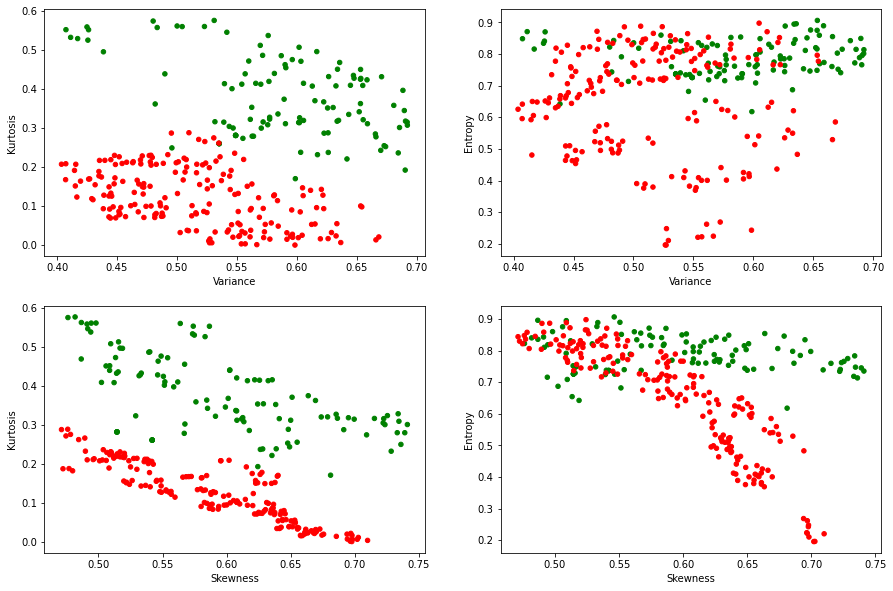

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
cf.plot.scatter(ax=ax[0, 0], x='Variance', y='Kurtosis', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[0, 1], x='Variance', y='Entropy', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[1, 0], x='Skewness', y='Kurtosis', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
cf.plot.scatter(ax=ax[1, 1], x='Skewness', y='Entropy', c=cf['Is Fake']\
                .apply(lambda x: 'r' if x == 1. else 'g'))
plt.show()

As it turns out, knowing the value of the input `Kurtosis` allows us to almost perfectly differentiate geniune notes from forgeries, among all notes that were previously ambiguous to tell apart solely using `Variance` and `Skewness`. On the other hand, although it helps alleviate some ambiguity, the input `Entropy` appears not as effective as `Kurtosis`.

Thus, the third input in decreasing order of marginal usefulness is expected to be `Kurtosis`, `Entropy` being the least marginally useful.

To summarize, we expect a decent variable selection analysis to select variables in the order `Variance` $\to$ `Skewness` $\to$ `Kurtosis` $\to$ `Entropy`. We expect the contribution of `Entropy` to be negligible, and the overall achievable accuracy to be close to 100%. 

### Validation 

Let us validate that the variable selection analysis of the `kxy` package satisfies these properties.

In [7]:
var_selection_analysis = ef.kxy.variable_selection('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s   


In [8]:
var_selection_analysis

,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
1,Variance,0.45,0.87
2,Skewness,0.51,0.90
3,Kurtosis,0.75,1.00
4,Entropy,0.75,1.00


The `kxy` package selected variables in the same order as our qualitative analysis (see the `Selection Order` column). Looks spot on!

## Data-Driven Improvability
We know that `Entropy` is useless and `Variance` is the most useful variable. Let's check just how much performance we would miss out on by leaving out one or the other.

In [9]:
ef_without_entropy = ef[['Variance', 'Skewness', 'Kurtosis', 'Is Fake']]
ef_without_entropy.kxy.data_valuation('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s   


,Achievable R-Squared,Achievable Log-Likelihood Per Sample,Achievable Accuracy
0,0.75,7.29e-04,1.00


Looks about right!

In [10]:
ef_without_variance = ef[['Skewness', 'Kurtosis', 'Entropy', 'Is Fake']]
ef_without_variance.kxy.data_valuation('Is Fake', problem_type='classification')

[====================================================================================================] 100% ETA: 0s   


,Achievable R-Squared,Achievable Log-Likelihood Per Sample,Achievable Accuracy
0,0.55,-2.92e-01,0.92


Interestingly, although `Variance`, when used by itself boosts the baseline accuracy by 12%, when excluded we only lose 8% accuracy. This suggests that `Skewness` and/or `Kurtosis` are/is somewhat related to `Variance`.